In [1]:
# Standard imports:
import lsst.daf.butler as dafButler
import lsst.afw.display as afwDisplay

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import healpy as hp
import astropy.units as u
from astropy.coordinates import SkyCoord
import astropy.units as u

import glob as glob
import os

from astropy.coordinates import Angle
import lsst.geom

In [2]:
afwDisplay.setDefaultBackend('matplotlib')
from lsst.rsp import get_tap_service
service = get_tap_service("tap")

In [3]:
# Butler setup and skyMap retrieval:
collections = 'LSSTComCamSim/runs/DRP/OR4/w_2024_25/DM-45066'
butler = dafButler.Butler('embargo_or4', collections=collections)
registry = butler.registry
skyMap = butler.get('skyMap', dataId={'skymap':'ops_rehersal_prep_2k_v1'})

In [4]:
# select_tract = 2494
# select_patch = 275
# select_tract = 2494
# select_patch = 155
# select_tract = 2494
# select_patch = 204
# select_tract = 2494
# select_patch = 138

In [5]:
class compare_static_truth_psf:
    def __init__(self, tract, patch):
        self.tract = tract
        self.patch = patch

    def get_objecttable(self):
        """
        Get objectTable for a tract and patch
        """
        tract_dataid = {'band': 'g', 'skymap': 'ops_rehersal_prep_2k_v1', 'tract': self.tract, 'patch': self.patch}
        obj_table = butler.get('objectTable', dataId=tract_dataid)
        obj_table = obj_table.reset_index()
        
        # select a bright object from g band 
        obj_table = obj_table[obj_table['refBand'] == 'g']
        obj_table = obj_table.sort_values('g_psfFlux', ascending=False)

        return obj_table
    
    # A funuction to determine the filename of a truthtable covering a DIA detecor image.
    def GetTruthFiles(self, RA, Dec):
        '''
        Given a set of coordinates, determine the filename of the pointsource parquet
        truth table that covers that region. This is needed because the parquet files
        are named according to the htm7 nside=32 region that they cover, so the index
        of the htm7 segment is needed to identify the file.
    
        Note
        ----
        This calculates the mean coordinate of the catalogue and uses that to
        determine the htm7 segment.
    
        Inputs
        ------
        RA: Pandas series containing the Right Ascention of sources in degrees.
        Dec: Pandas series containing the Deckination of sources in degrees.
    
        Outputs
        -------
        truthFiles: List of filenames of the truth table parquet files that cover the
                    region of interest.
        
        '''
        truthFiles = []
    
        mean_ra = np.deg2rad(np.mean(RA.value))
        mean_de = np.deg2rad(90. - np.mean(Dec.value))
        coordVec = hp.ang2vec(mean_de, mean_ra)
        ipix_discs = hp.query_disc(nside=32, vec=coordVec, radius=np.radians(2))
    
        for ipix_disc in ipix_discs:
            filename = '/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/pointsource_{}.parquet'.format(ipix_disc)
            if os.path.exists(filename):
                truthFiles.append(filename)        
        return truthFiles

    def find_match_truth_objtable(self, truthFile_parquet, obj_table_df):
        truthTable = pd.read_parquet(truthFile_parquet)
        
        # select static sources
        truthTable = truthTable[truthTable['is_variable'] == False]
        truthTable = truthTable.sort_values('magnorm', ascending=True)
        truthTable = truthTable[(truthTable['magnorm'] > 17.0) & (truthTable['magnorm'] < 19.0)]
        
        # cross match with the object table
        trueCoords = SkyCoord(ra=truthTable['ra'].values*u.degree, dec=truthTable['dec'].values*u.degree)
        objCoords = SkyCoord(ra=obj_table_df['coord_ra'].values*u.degree, dec=obj_table_df['coord_dec'].values*u.degree)
    
        idx, d2d, d3d = objCoords.match_to_catalog_sky(trueCoords) # idx is closest index in trueCoords
    
        # print('length of objCoords table: ',len(objCoords))
        # print('length of indices: ',len(idx))
    
        # select closest matche within 2"
        d2d_inx = np.where(d2d < 2*u.arcsec)
        idx = idx[d2d_inx]
        d2d = d2d[d2d_inx]
    
        return truthFile_parquet, idx

    def match_truth_forced(self, obj_table, obj_ra, obj_dec):
        # get truth files
        truthfile_match = 0
        idx_match = 0
        truthFiles = self.GetTruthFiles(obj_ra*u.degree, obj_dec*u.degree)
        for i, truthFile in enumerate(truthFiles):
            truthfile, idx = self.find_match_truth_objtable(truthFile, obj_table)
            if len(idx) != 0:
                truthfile_match = truthfile
                idx_match = idx[0]
                print(truthfile_match)
                print(idx_match)
                # get the truth table matched to object_table ra,dec
                truthTable = pd.read_parquet(str(truthfile_match))
                truthTable = truthTable[truthTable['is_variable'] == False]
                truthTable = truthTable.sort_values('magnorm', ascending=True)
                truthTable = truthTable[(truthTable['magnorm'] > 17.0) & (truthTable['magnorm'] < 19.0)]
                
                true_magnorm = truthTable['magnorm'][idx_match:idx_match+1].values[0]
                true_ra = truthTable['ra'][idx_match:idx_match+1].values[0]
                true_dec = truthTable['dec'][idx_match:idx_match+1].values[0]
            
                # get tract and patch for this true ra,dec
                my_spherePoint = lsst.geom.SpherePoint(true_ra*lsst.geom.degrees,
                                                       true_dec*lsst.geom.degrees)    
                tract = skyMap.findTract(my_spherePoint)
                patch = tract.findPatch(my_spherePoint)
                my_tract = tract.tract_id
                my_patch = patch.getSequentialIndex()
            
                # match the true ra,dec to forcedSourceTable ra,dec 
                STable = butler.get('forcedSourceTable', tract=my_tract, patch=my_patch, skymap = 'ops_rehersal_prep_2k_v1')
                trueCoords = SkyCoord(ra=true_ra*u.degree, dec=true_dec*u.degree)
                SCoords = SkyCoord(ra=STable['coord_ra'].values*u.degree, dec=STable['coord_dec'].values*u.degree)
                idx, d2d, d3d = trueCoords.match_to_catalog_sky(SCoords) #idx is closest index in SCoords
                forced_ra = STable[int(idx):int(idx+1)]['coord_ra'].values[0]
                forced_dec = STable[int(idx):int(idx+1)]['coord_dec'].values[0]
                forced_band = STable[int(idx):int(idx+1)]['band'].values[0]
                forced_flux = STable[int(idx):int(idx+1)]['psfFlux']
                forced_mag = (forced_flux.to_numpy()*u.nJy).to(u.ABmag).value[0]
    
                return true_ra, true_dec, true_magnorm, forced_ra, forced_dec, forced_band, forced_mag
            else:
                i+=1
                
        return 

In [6]:
truth_forced_dict = {'true_ra':[], 'true_dec':[], 'true_magnorm':[], 'forced_ra':[], 'forced_dec':[], 'forced_band':[], 'forced_mag':[]}
tracts = [2494, 2494, 2494, 2494]
patches = [275, 155, 204, 138]
for i in range(0, len(tracts)):
    select_tract = tracts[i]
    select_patch = patches[i]
    print(select_tract, select_patch)
    compare_flux = compare_static_truth_psf(select_tract , select_patch)
    obj_table = compare_flux.get_objecttable()
    obj_ra = obj_table.iloc[0]['coord_ra'] # select the brightes object from ObjectTable
    obj_dec = obj_table.iloc[0]['coord_dec']
    try:
        true_ra, true_dec, true_magnorm, forced_ra, forced_dec, forced_band, forced_mag = compare_flux.match_truth_forced(obj_table, obj_ra, obj_dec)
        truth_forced_dict['true_ra'].append(true_ra)
        truth_forced_dict['true_dec'].append(true_dec)
        truth_forced_dict['true_magnorm'].append(true_magnorm)
        truth_forced_dict['forced_ra'].append(forced_ra)
        truth_forced_dict['forced_dec'].append(forced_dec)
        truth_forced_dict['forced_band'].append(forced_band)
        truth_forced_dict['forced_mag'].append(forced_mag)
    except:
        continue


2494 275
/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/pointsource_10750.parquet
65522
2494 155
/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/pointsource_10859.parquet
31061
2494 204
/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/pointsource_10638.parquet
25270
2494 138
/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/pointsource_10859.parquet
36046


In [7]:
truth_forced_dict

{'true_ra': [279.3759794, 279.5363221, 279.8483674, 279.6130119],
 'true_dec': [-47.6096166, -48.3097825, -47.9207667, -48.3422405],
 'true_magnorm': [18.942261977058234,
  18.244831200383604,
  18.057870581889393,
  18.39504780774207],
 'forced_ra': [279.3759806138935,
  279.5363222248561,
  279.8484815302782,
  279.61309016924616],
 'forced_dec': [-47.60961546601434,
  -48.309782379809484,
  -47.92037308524051,
  -48.34228895696485],
 'forced_band': ['r', 'g', 'r', 'r'],
 'forced_mag': [17.841885169543158,
  18.511057335695796,
  16.116297470241566,
  15.387352945726482]}

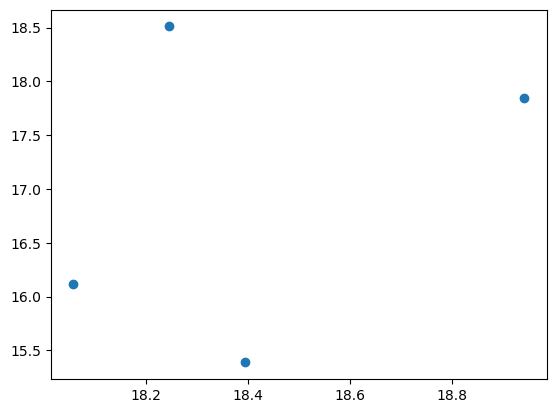

In [8]:
# plot true_mag and forced_mag
plt.scatter(truth_forced_dict['true_magnorm'], truth_forced_dict['forced_mag'])